**CS 481 Final Project**

The goal of this project is to classify tweets from members of U.S. congress by their political party. 

All files used for this project can be found on [my github repo here](https://github.com/GeorgeIIT/cs481project)

The file ['party_tweets.csv'](https://github.com/GeorgeIIT/cs481project/blob/main/party_tweets.csv) contains tweets and retweets from members of the US Congress. Each tweet is labeled with the congress member's party affiliation. The partys are Democrats and Republicans, Members of a third party were not included. Tweets were collected by pulling the last 40 tweets (retweets included) from each congress member's user timeline on 4/1/21. The goal for this repository is to predict the political party of a legislator based on the content they share online. It should be noted that these are official twitter accounts so the vast majority of the content posted is relevant to the user's political career. Models trained with this dataset may not be effective for predicting the party affiliation of non-political content, or political content from perspectives outside of the United States.

  * Total tweets: 21181
  * Democrat Tweets (D): 10956
  * Republican Tweets (R): 10225
  * Ratio: 52:48 D:R

The code used for collecting the twitter data is in ['Get_congress_tw_data.py'](https://github.com/GeorgeIIT/cs481project/blob/main/Get_congress_tw_data.py). If you wish to run it, you will need to provide your own twitter authentication tokens. Also be warned that it takes several hours to run because of the rate limit for twitter API calls.

Congress member twitter handles were found on [Triage Cancer's](https://triagecancer.org/congressional-social-media) website.

**Libraries Used**

In [26]:
#Data Representation
import numpy as np
import pandas as pd
import string

#Preprocessing Text
from tqdm import tqdm
import re
from bs4 import BeautifulSoup

#Vector Representaion
from sklearn.feature_extraction.text import CountVectorizer

#Train/Test Split
from sklearn.model_selection import train_test_split

#Logistic Regression and Naive Bayes 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

#Performance Evaluation
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc

#Parameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#Plotting (used to explore the data and evaluate model performance)
import matplotlib.pyplot as plt

**Load the Data**

In [27]:
#read in the data as a pandas dataframe, pipes (|) were used as delimiters. 
data = pd.read_csv('party_tweets.csv',sep='|',engine='python',encoding='utf-8',quoting=3)
#make sure pandas does not truncate display
pd.set_option('display.max_colwidth', -1) 
'''
my version of pandas seems to be out of date, so if you get warnings related to the '-1' arg above, 
use the line below instead. '-1' is deprecated but 'none' will not work for me. 
'''
#pd.set_option('display.max_colwidth', none) 
data.shape, display(data.head())

<ipython-input-27-1af46405514a>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,idx,tweet,party
0,0,"Happy birthday, @SenatorLeahy. Grateful for our longstanding friendship and willingness to work together on the Senate Appropriations Committee. Looking forward to another productive year.",R
1,1,Pleased that 20 airports throughout Alabama will benefit from more than $11.2M in @FAAnews grants. These @USDOT funds will help airports receive the upgrades and enhancements needed to continue serving local communities and driving economic development. <webLink>,R
2,2,More information regarding my letter: <webLink>,R
3,3,"Today I sent a letter to @Amtrak, @CSX, @nscorp, & Surface Transportation Board stating that a data-driven process is essential prior to starting new passenger rail in Mobile. A comprehensive study would alleviate concerns re how the new service could impact growth in the area. <webLink>",R
4,4,🚨LIVE NOW🚨Senate GOP is on the ground discussing the crisis at the border.Tune in here! ⤵️ <webLink>,R


((21182, 3), None)

**Exploring the Data**

empty cells:
idx      0
tweet    0
party    0
dtype: int64

Shape before dropping duplicates:
(21182, 3)
Shape after dropping duplicates:
(21171, 3)

Distribution of classes:
D    10956
R    10215
Name: party, dtype: int64

Tweet character length info:
count    21171.000000
mean     199.848425  
std      74.182438   
min      3.000000    
25%      148.000000  
50%      220.000000  
75%      262.000000  
max      735.000000  
Name: length, dtype: float64


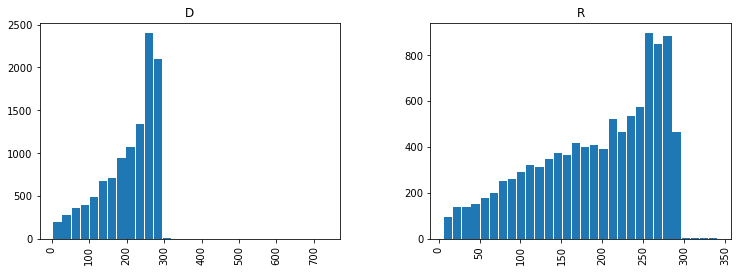

,tweet,party,length
3037,"@LisaBRochester @AnnMcLaneKuster @CarolynBMaloney @val_demings @wildforcongress @StricklandforWA @SpanbergerVA07 @KatherineClark @AlmaforCongress @Lizzie4Congress @LindaTSanchez @JoyceBeatty @LoisFrankel @dinatitus @lucymcbath @DeborahRossNC @JackieSpeier @AOC @RobinLynneKelly @SMurphyCongress @ElaineLuriaVA @RepSchakowsky @Marcy_Kaptur @LaurenUnderwood @ElissaSlotkin @Matsui4Congress @vgescobar @AyannaPressley @Axne4Congress @Bonnie4Congress Congresswoman @KathyManningNC worked as a nonprofit leader, helping to create opportunity for #NC06 families with equity in education and health care.As a small business owner, she developed a passion for an economy that truly rewards hard work & innovation. #WomensHistoryMonth <webLink>",D,735


In [28]:
#check empty cells (should be 0 for this dataset)
print("empty cells:\n{}".format(data.isnull().sum()))

#drop duplicate entries, this data set happens to have 10
print("\nShape before dropping duplicates:\n{}".format(data.shape))
data = data.drop_duplicates(keep="first")
print("Shape after dropping duplicates:\n{}".format(data.shape))

#dropping the index given in the .csv file so it is not confused wit hthe pandas index 
data = data.drop(['idx'],axis=1)

#data is sorted by legislator in 40 tweet chunks, we need to shuffle them and reset the index
data = data.sample(frac=1, random_state=13).reset_index(drop=True)

#check the balance of the data
print("\nDistribution of classes:\n{}".format(data.party.value_counts()))

#take a look at the length of the tweets, this also adds a new column to the dataset
data['length'] = data['tweet'].apply(len)
print("\nTweet character length info:\n{}".format(data['length'].describe()))

#get a visualization of the length distribution by party
data.hist(column='length',by='party',bins=30,figsize=(12,4),rwidth=0.9)
plt.show()

#lets see a tweet that was over 280 chars
data.query('length > 700')

You can see above that most tweets max out at 280 charecters, Twitter's current charecter limit. There are a few outliers that changed the scale of the two graphs though. These posts were able to excceed the limit becuase mentions of other users do not count towards the charechter limit. Chains of mentions can create very long tweets like this.

**Preprocessing the Data**

These three functions are going to be used to clean up the data. Mainly expanding contractions and removing special charecters. But the last one converts the party label from D and R to 0 and 1 respectively. 

In [29]:
def decontracted(phrase):
    """
    We first define a function to expand the contracted phrase into normal words
    """
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase) # prime 
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase
def clean_text(df):
    """
    Clean the review texts
    """
    cleaned_review = []
    
    for tweet_text in tqdm(df['tweet']):
        
        #remove twitter handles
        #tweet_text = re.sub(r'@\S+',"", tweet_text)
        
        #remove hashtags
        #tweet_text = re.sub(r'#\S+',"", tweet_text)
        
        # expand the contracted words
        tweet_text = decontracted(tweet_text)
        
        #remove html tags
        tweet_text = BeautifulSoup(tweet_text, 'lxml').get_text().strip() # re.sub(r'<.*?>', '', text)
        
        #remove non-alphabetic characters
        tweet_text = re.sub("[^a-zA-Z]"," ", tweet_text)
    
        #the urls from tweets were replaced with '<weblink>', get rid of them here
        tweet_text = tweet_text.replace('<weblink>', '')
        
        #removing punctutation, string.punctuation in python consists of !"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`
        tweet_text = tweet_text.translate(str.maketrans('', '', string.punctuation))
        # ''.join([char for char in movie_text_data if char not in string.punctuation])
        
        #remove emails
        tweet_text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", '', tweet_text)
        
        cleaned_review.append(tweet_text)

    return cleaned_review

def convert_party_to_number(df):
    converted_label = []
    for numeric_party in df['party']:
        if(numeric_party == 'D'):
            numeric_party = 0
        else:
            numeric_party = 1
        converted_label.append(numeric_party)
    return converted_label

In [30]:
data['cleaned_tweet'] = clean_text(data)
data['numeric_party'] = convert_party_to_number(data)

100%|██████████████████████████████████████████████████████████████████████████| 21171/21171 [00:13<00:00, 1572.31it/s]


Data after cleaning

In [31]:
data.shape, display(data.head())

,tweet,party,length,cleaned_tweet,numeric_party
0,From top to bottom #HR1 is a bad idea <webLink>,R,47,From top to bottom HR is a bad idea,1
1,"Great news for our small biz in SW MI! Republicans & Democrats have reached a bipartisan deal to extend the job-saving #PaycheckProtectionProgram, helping to continue our economic recovery. #MI06<webLink>",R,204,Great news for our small biz in SW MI Republicans Democrats have reached a bipartisan deal to extend the job saving PaycheckProtectionProgram helping to continue our economic recovery MI,1
2,I testified to the House Ways and Means Committee to make clear that any legislative effort to change our tax laws this year must address the SALT deduction. <webLink>,D,167,I testified to the House Ways and Means Committee to make clear that any legislative effort to change our tax laws this year must address the SALT deduction,0
3,Happy Palm Sunday to those who observe. May this special week bring blessings to you and your family. <webLink>,R,111,Happy Palm Sunday to those who observe May this special week bring blessings to you and your family,1
4,“A government that robs Peter to pay Paul can always count on the support of Paul.” - George Bernard Shaw,R,105,A government that robs Peter to pay Paul can always count on the support of Paul George Bernard Shaw,1


((21171, 5), None)

**Parameter Tuning with Grid Search**

This search tries to find the best vectorizer and model parameters for logistic regression.

In [11]:
vectorizer = CountVectorizer(lowercase=True,stop_words=stopwords)
logistic = LogisticRegression(max_iter=1000,solver='lbfgs')

#build a pipeline
pipe = Pipeline(steps = [('vectorizer',vectorizer),
                         ('classifier',logistic)])

#dictionary for model params and corresponding values
param_grid = {
    'vectorizer__min_df':[1,2,3],
    'vectorizer__max_df':[0.6,0.7,0.8],
    'vectorizer__ngram_range':[(1,1),(1,2),(2,2),(1,3)],
    'classifier__penalty':['none','l2']
}

search_result = GridSearchCV(pipe,param_grid,cv=4,scoring='f1',n_jobs=6).fit(data.cleaned_tweet.values, data.numeric_party.values)

print("Best parameter (CV score = %0.3f):" % search_result.best_score_)
print(search_result.best_params_)

Best parameter (CV score = 0.816):
{'classifier__penalty': 'l2', 'vectorizer__max_df': 0.6, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2)}


**Vectorizing The Data**

Below is the set of stopwords that will be ignored by the count vectorizer. 

In [32]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't","no","nor","not"])

In [33]:
vectorizer = CountVectorizer(lowercase=True,stop_words=stopwords,max_df=0.6,min_df=1,ngram_range=(1,2))
#convert the celaned tweets into vectors, store them in X. Party labels stored in Y
X = vectorizer.fit_transform(data['cleaned_tweet'])
Y = data['numeric_party']
#print(X.toarray()[0])
print("Vector Shape:\t\t", X.shape)
print("Party Label Shape:\t", Y.shape)

Vector Shape:		 (21171, 251318)
Party Label Shape:	 (21171,)


**Train Test Split** 

Here I used an 80% training and 20% testing split to partition the data. 

In [34]:
train_idx, test_idx = train_test_split(np.arange(data.shape[0]), test_size=0.25, shuffle=True, random_state=42)

#show split
print("Number of training examples:\t", len(train_idx))
print("Number of testing examples:\t", len(test_idx))

#train/test split the data
X_train = X[train_idx]
Y_train = Y[train_idx]
X_test = X[test_idx]
Y_test = Y[test_idx]

#show shape of each partition
print("\nTraining data:\nX: {}, Y: {}".format(X_train.shape,Y_train.shape))
print("\nTesting data:\nX: {}, Y: {}".format(X_test.shape,Y_test.shape))

Number of training examples:	 15878
Number of testing examples:	 5293

Training data:
X: (15878, 251318), Y: (15878,)

Testing data:
X: (5293, 251318), Y: (5293,)


**Fitting the Logistic Regreassion**

In [35]:
#fit the logistic regression
lr_clf = LogisticRegression(max_iter=1000,solver='lbfgs',penalty='l2')
lr_clf.fit(X_train, Y_train)
y_pred_test = lr_clf.predict(X_test)
y_predprob_test = lr_clf.predict_proba(X_test)

**Evaluating Performance**

First looking at the classification report and CV scores for logistic regression

In [36]:
#check out how well the model performed
print("Classification Report:\n", classification_report(Y_test, y_pred_test))
scores = cross_val_score(lr_clf, X, Y, cv=4, scoring='f1')
print("Cross Validation Scores:\n",scores)

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82      2804
           1       0.79      0.83      0.81      2489

    accuracy                           0.81      5293
   macro avg       0.81      0.81      0.81      5293
weighted avg       0.81      0.81      0.81      5293

Cross Validation Scores:
 [0.81239176 0.81959565 0.819151   0.81365135]


Now the ROC curve

Note that republicans were chosen as the "positive" label. This was an arbitrary decision following the labels 0 and 1 for D and R.  

Examples of labeled data

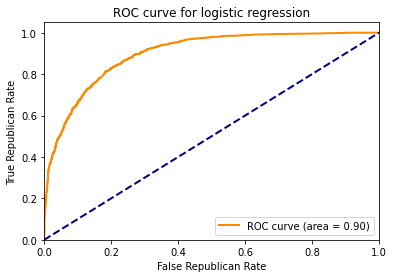

In [37]:
fpr, tpr, thresholds = roc_curve(y_true = Y_test, y_score = y_predprob_test[:,1], pos_label=1)
roc_auc = auc(fpr, tpr) # area under ROC curve

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Republican Rate')
plt.ylabel('True Republican Rate')
plt.title('ROC curve for logistic regression')
plt.legend(loc="lower right")
plt.show()

Examples of data labels

In [38]:
lr_data_test = data.loc[test_idx]
lr_data_test['pred_party'] = y_pred_test
lr_data_test['pred_prob'] = y_predprob_test[:,1]
lr_data_test.head()[['tweet','numeric_party','pred_party','pred_prob']]

,tweet,numeric_party,pred_party,pred_prob
1457,"This isn't just a #BorderCrisis, it is a national crisis.<webLink>",1,1,0.808355
20771,"Thank you President Biden! I look forward to working with @POTUS on how to implement his historic commitment to protecting and uplifting AAPI communities. #StopAsianHate"" <webLink>",0,0,0.008705
16581,I am going spend the next few weeks working my tail off to find 60 votes for a bill that expands background checks. I’m not interested in this issue becoming a permanent political cudgel. Let’s get something done that saves lives. <webLink>,0,0,0.120160
11324,An ambitious and important goal that will end the pandemic and help get our lives back to normal. <webLink>,0,0,0.115033
1114,"I've got a few days until the end-of-quarter fundraising deadline.I need to send a STRONG message to the Left as they desperately try to smear me day in & day out.Let's raise another $150,000 before the end of the quarter. Donate what you can today: <webLink>",1,1,0.653449


Top features for each party

In [39]:
feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(vectorizer.get_feature_names(), lr_clf.coef_[0])}

print("\nTop democrat features:")
for item in (sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:20]):
    print(item)
    
print("\nTop republican features:")
for item in (sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:20]):
    print(item)


Top democrat features:
('americanrescueplan', -3.419)
('stopasianhate', -2.069)
('az', -1.681)
('democracy', -1.606)
('buildbackbetter', -1.599)
('guam', -1.456)
('msnbc', -1.453)
('forthepeople', -1.353)
('dcstatehood', -1.346)
('black', -1.337)
('american rescue', -1.33)
('transgender', -1.302)
('rescue plan', -1.295)
('chair', -1.289)
('sameach happy', -1.213)
('help way', -1.208)
('nj', -1.182)
('transportdems', -1.163)
('transdayofvisibility', -1.156)
('pandemic', -1.154)

Top republican features:
('bidenbordercrisis', 2.2)
('realdonaldtrump', 2.105)
('democrats', 1.816)
('border', 1.741)
('china', 1.671)
('oklahoma', 1.455)
('ccp', 1.419)
('idaho', 1.334)
('get vote', 1.327)
('partisan', 1.305)
('spending', 1.304)
('utpol', 1.297)
('ohio', 1.295)
('god', 1.289)
('pelosi', 1.283)
('nuclear', 1.248)
('alaska', 1.229)
('louisiana', 1.203)
('hogs', 1.202)
('mi', 1.19)


As a regular observer of American politics, these top features make a lot of sense to me. A large portion of the words relate to very recent events in politics. This makes sense becuase the dataset only contains the 40 most recent tweets from the legislators. Since Legislators have an incentive to post often and keep their constituents up to date, the oldest of these tweets only date back a few weeks or months depending on the specific user.

I think the topics being discussed here fit into what I would expect from each party. 

Democrats tend to advocate more for civil rights issues. Here are a few examples of that:

* 'stopasianhate' refers to the Atlanta spa shootings and ongoing COVID related racism towards Asian Americans.
* 'transgender' discussion is likely related to laws being discussed in several states that are seen as discriminating against transgender people.
* 'black' is also related to rascism in America, escpecially police brutality and the Black Lives Matter protests we saw over the summer. 

Republicans typically have more nationalist views and will talk about other countries and how they have an impact on the United States. Several other words that fit into the Republican agenda also come up:

* 'bidenbordercrisis' and 'border' are both about the US-Mexico border. Republicans are in favor of Trump's border wall and stronger immigration policies on this border. 'bidenbordercrisis' is a more specific and recent example of this anti-immigration stance. Discussion about a crisis at the border started when President Biden halted construction of Former President Trump's border wall. 
* 'china' and 'ccp' (Chinese Communist Party) are typically dicussed by Republicans in the context of China's economic strength. The Republican party sees the country's success here as a threat to American jobs. Recently Republicans have also been placing blame on China's government for it's handling of the COVID-19 pandemic. 
* 'spending' relates to complaints over policy descisions made by Democrats. Republicans are known for believeing in small government. So they argue for lower taxes and lower spending. 
* 'god', usually in the form of 'god bless' based on what I saw, was also unsurprising to me. Republicans seem to invoke the Christian god more often than democrats. Some of these tweets were actually bible verses. They also cite the religion for some of their political stances such as being anti-abortion. 

I also thought it was very interesting that Republicans seem to be talking a lot about Democrats. Democrats are not doing the same for the Republican party:

* 'bidenbordercrisis' refers to the Biden Administration's US-Mexico border policy.
* 'democrats' is pretty self explanitory, talking about their opposition in numerous contexts.
* 'pelosi' refers to Nancy Pelosi, the California Democrat and House Majority Leader. 
* 'partisan' is an accusatory term. It's referring to laws proposed by Democrats that Republicans believe are not considering their party's beliefs.

Instead, democrats are talking a lot about the legislation they want passed:

* 'americanrescueplan', 'buildbackbetter', 'american rescue', and 'rescue plan' come from the American Rescue Plan Act of 2021. 
* 'dcstatehood' comes from the push to grant statehood to Washington D.C. Congress holds the power to grant statehood and Democrats want this to happen.
* 'transportdems' is the twitter handle of the House Committee on Transportation and Infrastructure. It has been planning new legislation that house democrats are advocating for. 
* 'forthepeople' is a hashtag that has been used to promote the For the People Act of 2021. 

My theory on why the Republicans talk about Democrats so much is because they have just lost a significant ammount of power. After the 2020 election, Democrats gained control of the senate and white house. They also maintained control of the house. I think the Republicans are trying to point out what they think Democrats are doing wrong as if to say "look what you voted for, this is why it's bad". Democrats, having just gained power, are more interested in explaining what they are doing now that they are in control. I'm interested in collecting a similar dataset with tweets from four years ago. This was right after the 2016 election where Democrats had found themselves in a similar situation. If they talked more about Republicans at that time I think it would support my theory. 

Since this dataset only contains a few months of data you'll also see several words from reactions to current events. If tweets were collected from further back in time I don't think we would see things like this. I don't have much to say about them but I thought I'd list a few as examples.

* 'guam' was talked about because House Rep Marjorie Taylor Green made news headlines for appearing to think the U.S. territory was a foreign nation. 
* 'nuclear' was discussed in two contexts. The Iran and the Biden Administration are interested in restoring the Iran Nuclear Deal. Nuclear enegry was also talked about a lot. 
* 'get vote' is actually from the phrase 'get out and vote' which is common around elections. 'out' and 'and' were removed as stop words, so we are left with 'get vote'. 
* 'sameach happy' is another case of stop word removal. They were actually saying 'sameach and happy' as in 'chag sameach and happy passover' to celebrate the jeweish holiday. 


Examples of mislabeled data

In [40]:
lr_data_test[lr_data_test['numeric_party'] != lr_data_test['pred_party']].head()[['tweet','numeric_party','pred_party','pred_prob']]

,tweet,numeric_party,pred_party,pred_prob
10498,"Democracy is essential to the prosperity and well-being of people around the world. Yet, we're seeing the global retreat of freedom. We must focus on our soft power and link arms with like-minded nations to promote democracy, countering the malevolent efforts of Russia and China. <webLink>",1,0,0.375048
19259,The world is a better place today thanks to the service and sacrifice of those who fought against tyranny during WWII.We should give them the highest quality care available without a second thought. <webLink>,1,0,0.128872
8342,"NEWS: Yesterday the House passed a bipartisan piece of legislation, which I was proud to co-sponsor, that would extend the deadline for application to the Paycheck Protection Program for small businesses.Learn more ⬇️<webLink>",0,1,0.833745
2315,92-7: Senate passes legislation extending the Paycheck Protection Program (PPP) by two months until May 31st. SBA's COVID-19 small business relief program is set to expire March 31st. 60 votes were needed. House passed bill 415-3 on March 16th and it now heads to President Biden. <webLink>,0,1,0.871920
14936,It was a pleasure joining Norfolk Councilmember Andria McClellan and my team at the Great American Cleanup in Sarah Constant Beach Park today! I enjoyed rolling up my sleeves to help keep our community clean and beautiful. <webLink>,0,1,0.747035


I see three reasons that could be causing these tweets to be mislabeled. 

* The first is probably the most mundane. Look at tweets 19259, 2315, and 14936 (2nd, 4th, and 5th) shown above. They don't contain anything that really indicates a party's values. The first is thanking american veterans, and the latter two are simpley updates on their actions. I see these as blanket statements that show their constituants two things; "I care about our veterans", and "Legislation is happenning, I'm doing my job". I see a few words in these posts that are likely to have contributed to the misclassification like "biden" in 2315.


* The second is also not so interesting. Tweet 8342 (3rd) is actually a legislator retweeting from a reporter, Craig Caplan. The text of the tweet is somewhat similar to those I discussed above; just updating constituants on some action being taken. I might consider excluding retweets from my data in future models. 


* The third reason I found very interesting. Tweet 10498 (1st) comes from Senator Mitt Romney (image shown below). Recently, he has been heavily critiscized by members of his party, the GOP, for his views on former president Trump and the 2020 election, among other things. In this tweet he is talking about election interference and online propaganda spread by Russia and China. This topic is largely disregarded by others in the republican party. Democrats on the other hand, widely accept the idea that this foreign election interference happened. I think this miscarecterization actually demonstrates the disagreement here between Sen. Romney and his Republican collegues. One of the features that lead to this misclassification was his use of the word "democracy" twice. This is a top feature for democrats.  

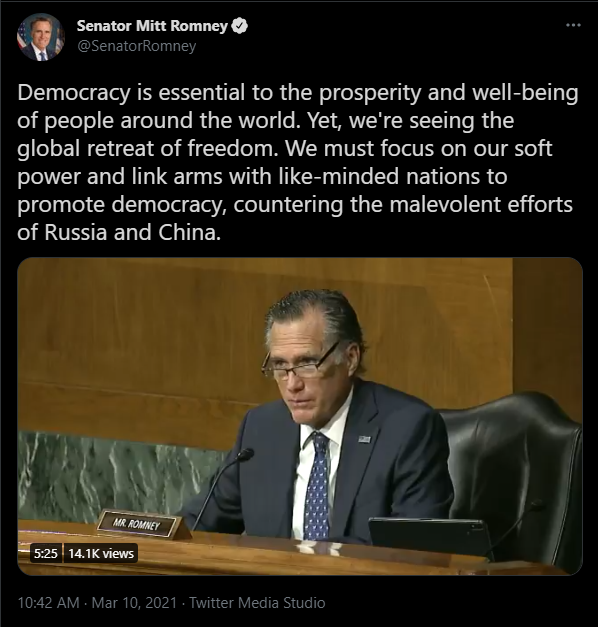

In [41]:
from IPython import display
display.Image("imgs/mislabeledRomney.png")